# Portfolio Optimization using QUBO and Qiskit

This notebook demonstrates the use of QUBO (Quadratic Unconstrained Binary Optimization) for solving the optimal portfolio problem.

## Problem

We have 10 stocks with different expected returns and risks. We want to select a portfolio that:
* Maximizes expected return
* Minimizes risk (volatility)
* Selects exactly 5 stocks (budget constraint)

In [ ]:
# !pip install qiskit qiskit-optimization qiskit-algorithms qiskit-aer numpy matplotlib --break-system-packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_algorithms import QAOA, NumPyMinimumEigensolver
from qiskit_algorithms.optimizers import COBYLA
from qiskit.primitives import StatevectorSampler

## Portfolio Data Definition

We have 10 stocks with the following characteristics:

In [2]:
asset_names = [
    "Apple (Tech)",
    "Microsoft (Tech)",
    "ExxonMobil (Energie)",
    "Chevron (Energie)",
    "JPMorgan (Finance)",
    "Bank of America (Finance)",
    "Johnson & Johnson (Healthcare)",
    "Pfizer (Healthcare)",
    "Walmart (Retail)",
    "Amazon (E-commerce)",
]

n_assets = len(asset_names)

expected_returns = np.array([
    24.30,  # Apple - high growth
    31.91,  # Microsoft - high growth
    8.50,   # ExxonMobil - dividends
    2.22,   # Chevron - dividends
    34.70,  # JPMorgan - very high growth
    18.88,  # Bank of America - medium
    7.88,  # Johnson & Johnson - healthcare growing
    -12.14,  # Pfizer - pharmaceuticals
    30.72,   # Walmart - stable
    29.12   # Amazon - high growth, but risky
])

volatility = np.array([
    27.49,  # Apple - high volatility
    24.37,  # Microsoft
    23.17,  # ExxonMobil - commodities volatility
    22.77,  # Chevron
    22.95,  # JPMorgan - financial sector
    25.92,  # Bank of America
    17.05,  # Johnson & Johnson - defensive
    24.31,  # Pfizer
    19.88,  # Walmart - very stable
    33.19   # Amazon - highest volatility
])

# - Tech-Tech: High (0.7-0.85)
# - Energie-Energie: High (0.75-0.8)
# - Finance-Finance: High (0.7-0.8)
# - Healthcare-Healthcare: Medium (0.5-0.6)
# - Tech-Finance: Mediu (0.4-0.5)
# - Tech-Energie: Low (0.2-0.3)
# - Healthcare-Energie: Very low (0.1-0.2)

covariance_matrix = np.array([
    # Apple, MSFT, Exxon, Chev, JPM, BoA, J&J, Pfiz, Walmart, Amazon
    [755.83, 370.69, 148.11, 176.32, 206.05, 240.59,  40.68, 130.87, 164.90, 449.34],  # Apple
    [370.69, 593.93,  36.07,  80.90, 164.99, 169.12,  -9.80,  73.54, 117.29, 517.96],  # Microsoft
    [148.11,  36.07, 536.95, 437.26, 201.04, 237.14,  66.76, 107.09,  56.04,  71.92],  # ExxonMobil
    [176.32,  80.90, 437.26, 518.55, 226.51, 260.45,  67.81, 125.63,  67.92, 124.28],  # Chevron
    [206.05, 164.99, 201.04, 226.51, 526.48, 446.34,  61.15, 105.61, 120.55, 256.44],  # JPMorgan
    [240.59, 169.12, 237.14, 260.45, 446.34, 672.05,  63.47, 127.60, 135.94, 287.93],  # Bank of America
    [ 40.68,  -9.80,  66.76,  67.81,  61.15,  63.47, 290.59, 180.15,  58.36, -40.56],  # Johnson & Johnson
    [130.87,  73.54, 107.09, 125.63, 105.61, 127.60, 180.15, 590.85,  61.37,  68.90],  # Pfizer
    [164.90, 117.29,  56.04,  67.92, 120.55, 135.94,  58.36,  61.37, 395.35, 177.45],  # Walmart
    [449.34, 517.96,  71.92, 124.28, 256.44, 287.93, -40.56,  68.90, 177.45,1101.62],  # Amazon
])

for i, name in enumerate(asset_names):
    print(
        f"{name:<15s}: Yield={expected_returns[i]:5.1f}%, Risk={volatility[i]:5.1f}%"
    )

Apple (Tech)   : Yield= 24.3%, Risk= 27.5%
Microsoft (Tech): Yield= 31.9%, Risk= 24.4%
ExxonMobil (Energie): Yield=  8.5%, Risk= 23.2%
Chevron (Energie): Yield=  2.2%, Risk= 22.8%
JPMorgan (Finance): Yield= 34.7%, Risk= 22.9%
Bank of America (Finance): Yield= 18.9%, Risk= 25.9%
Johnson & Johnson (Healthcare): Yield=  7.9%, Risk= 17.1%
Pfizer (Healthcare): Yield=-12.1%, Risk= 24.3%
Walmart (Retail): Yield= 30.7%, Risk= 19.9%
Amazon (E-commerce): Yield= 29.1%, Risk= 33.2%


## QUBO Problem Formulation

We transform the problem into QUBO format:

**Objective function:**
```
Minimize: risk_factor × Σᵢⱼ xᵢ·Covᵢⱼ·xⱼ - return_factor × Σᵢ xᵢ·Rᵢ + penalty × (Σᵢ xᵢ - budget)²
```

where:
- `xᵢ ∈ {0,1}` indicates whether we select stock i
- `Covᵢⱼ` is the covariance matrix (risk)
- `Rᵢ` are the expected returns
- `budget` is the number of stocks we want to select

In [3]:
budget = 5              # Select 5 out of 10 stocks
risk_factor = 0.003     # Reduced due to larger covariances
return_factor = 3.0     # Increased for better motivation
penalty = 150.0         # Strong penalty
reps = 3                # More QAOA layers for more complex problem

print(f"  - Risk factor: {risk_factor}")
print(f"  - Return factor: {return_factor}")
print(f"  - Budget: {budget} stocks")
print(f"  - Penalty: {penalty}")

# Create QUBO problem
qp = QuadraticProgram('portfolio_optimization')

for i in range(n_assets):
    qp.binary_var(name=f'x_{i}')

# LINEAR PART
linear = {}
for i in range(n_assets):
    linear[f'x_{i}'] = -return_factor * expected_returns[i]
    linear[f'x_{i}'] += penalty * (1 - 2 * budget)

# QUADRATIC PART
quadratic = {}
for i in range(n_assets):
    for j in range(i+1, n_assets):
        key = (f'x_{i}', f'x_{j}')
        risk_term = 2 * risk_factor * covariance_matrix[i][j]
        penalty_term = 2 * penalty
        quadratic[key] = risk_term + penalty_term

# CONSTANT TERM
constant = penalty * budget ** 2

# Construct objective function
qp.minimize(linear=linear, quadratic=quadratic, constant=constant)

  - Risk factor: 0.003
  - Return factor: 3.0
  - Budget: 5 stocks
  - Penalty: 150.0


## Solution using Classical Algorithm (Reference Solution)

Classical solution for comparison:
- **Optimal value**: [value]
- **Selected stocks**: 
  -  [Stock name] (Return: X%, Risk: Y%)
- **Total expected return**: X%
- **Total portfolio risk**: Y
- **Sharpe ratio**: Z

**Solution description:**
- 1) Converts QUBO to Hamiltonian
- 2) Calculates all eigenvalues using NumPy/SciPy
- 3) Finds the minimum = optimal solution

In [4]:
exact_solver = NumPyMinimumEigensolver()
exact_optimizer = MinimumEigenOptimizer(exact_solver)
exact_result = exact_optimizer.solve(qp)

print(f"Objective function value: {exact_result.fval:.2f}")
print(f"\nDebug - x vector: {exact_result.x}")

selected_exact = []
print("\nSelected stocks:")
print("-" * 70)
for i in range(n_assets):
    value = exact_result.x[i]
    if value > 0.5:
        selected_exact.append(i)
        print(f"  ✓ x_{i} = {value:.3f} | {asset_names[i]:<15s} | "
              f"Return: {expected_returns[i]:5.1f}% | Risk: {volatility[i]:5.1f}%")
    else:
        print(f"  ✗ x_{i} = {value:.3f} | {asset_names[i]:<15s}")

print(f"\nTotal stocks selected: {len(selected_exact)} (target: {budget})")

if len(selected_exact) > 0:
    total_return_exact = sum(expected_returns[i] for i in selected_exact)
    total_risk_exact = np.sqrt(sum(covariance_matrix[i][j]
                                   for i in selected_exact
                                   for j in selected_exact))

    print(f"Total expected return: {total_return_exact:.2f}%")
    print(f"Total portfolio risk: {total_risk_exact:.2f}")
    print(f"Sharpe ratio: {total_return_exact/total_risk_exact:.3f}")
else:
    total_return_exact = 0
    total_risk_exact = 0

Objective function value: -436.98

Debug - x vector: [1. 1. 0. 0. 1. 0. 0. 0. 1. 1.]

Selected stocks:
----------------------------------------------------------------------
  ✓ x_0 = 1.000 | Apple (Tech)    | Return:  24.3% | Risk:  27.5%
  ✓ x_1 = 1.000 | Microsoft (Tech) | Return:  31.9% | Risk:  24.4%
  ✗ x_2 = 0.000 | ExxonMobil (Energie)
  ✗ x_3 = 0.000 | Chevron (Energie)
  ✓ x_4 = 1.000 | JPMorgan (Finance) | Return:  34.7% | Risk:  22.9%
  ✗ x_5 = 0.000 | Bank of America (Finance)
  ✗ x_6 = 0.000 | Johnson & Johnson (Healthcare)
  ✗ x_7 = 0.000 | Pfizer (Healthcare)
  ✓ x_8 = 1.000 | Walmart (Retail) | Return:  30.7% | Risk:  19.9%
  ✓ x_9 = 1.000 | Amazon (E-commerce) | Return:  29.1% | Risk:  33.2%

Total stocks selected: 5 (target: 5)
Total expected return: 150.75%
Total portfolio risk: 92.00
Sharpe ratio: 1.639


## Solution using Quantum Algorithm QAOA

QAOA (Quantum Approximate Optimization Algorithm) is a hybrid quantum-classical algorithm that:
- Uses a quantum computer to explore the state space
- Uses a classical optimizer to find the optimal parameters
- Iteratively improves the solution through multiple layers (reps)
- Can potentially outperform classical methods for large-scale problems

**Solution description:**
- 1) Creates a quantum circuit with parameters θ (theta)
- 2) Quantum circuit explores the state space using superposition
- 3) Measures the result (sampling)
- 4) Classical optimizer (COBYLA) adjusts parameters θ
- 5) Repeats steps 2-4 (iteratively)

In [5]:
try:
    sampler = StatevectorSampler()
    optimizer = COBYLA(maxiter=150)
    reps = 3

    print(f"Number of layers (reps): {reps}")

    qaoa = QAOA(sampler=sampler, optimizer=optimizer, reps=reps)
    qaoa_optimizer = MinimumEigenOptimizer(qaoa)
    qaoa_result = qaoa_optimizer.solve(qp)

    print(f"Objective function value: {qaoa_result.fval:.2f}")
    print(f"\nDebug - x vector: {qaoa_result.x}")

    selected_qaoa = []
    print("\nSelected stocks:")
    print("-" * 70)
    for i in range(n_assets):
        value = qaoa_result.x[i]
        if value > 0.5:
            selected_qaoa.append(i)
            print(f"  ✓ x_{i} = {value:.3f} | {asset_names[i]:<15s} | "
                  f"Return: {expected_returns[i]:5.1f}% | Risk: {volatility[i]:5.1f}%")
        else:
            print(f"  ✗ x_{i} = {value:.3f} | {asset_names[i]:<15s}")

    print(f"\nTotal stocks selected: {len(selected_qaoa)} (target: {budget})")

    if len(selected_qaoa) > 0:
        total_return_qaoa = sum(expected_returns[i] for i in selected_qaoa)
        total_risk_qaoa = np.sqrt(sum(covariance_matrix[i][j] 
                                      for i in selected_qaoa 
                                      for j in selected_qaoa))

        print(f"Total expected return: {total_return_qaoa:.2f}%")
        print(f"Total portfolio risk: {total_risk_qaoa:.2f}")
        print(f"Sharpe ratio: {total_return_qaoa/total_risk_qaoa:.3f}")
    else:
        total_return_qaoa = 0
        total_risk_qaoa = 0

    qaoa_success = True

except Exception as e:
    print(f"\nERROR: {e}")
    selected_qaoa = []
    qaoa_result = exact_result
    total_return_qaoa = total_return_exact
    total_risk_qaoa = total_risk_exact
    qaoa_success = False

Number of layers (reps): 3


B:\python\myqiskit\Lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:606: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
B:\python\myqiskit\Lib\site-packages\scipy\sparse\linalg\_matfuncs.py:707: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  return spsolve(Q, P)
B:\python\myqiskit\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])


Objective function value: -436.98

Debug - x vector: [1. 1. 0. 0. 1. 0. 0. 0. 1. 1.]

Selected stocks:
----------------------------------------------------------------------
  ✓ x_0 = 1.000 | Apple (Tech)    | Return:  24.3% | Risk:  27.5%
  ✓ x_1 = 1.000 | Microsoft (Tech) | Return:  31.9% | Risk:  24.4%
  ✗ x_2 = 0.000 | ExxonMobil (Energie)
  ✗ x_3 = 0.000 | Chevron (Energie)
  ✓ x_4 = 1.000 | JPMorgan (Finance) | Return:  34.7% | Risk:  22.9%
  ✗ x_5 = 0.000 | Bank of America (Finance)
  ✗ x_6 = 0.000 | Johnson & Johnson (Healthcare)
  ✗ x_7 = 0.000 | Pfizer (Healthcare)
  ✓ x_8 = 1.000 | Walmart (Retail) | Return:  30.7% | Risk:  19.9%
  ✓ x_9 = 1.000 | Amazon (E-commerce) | Return:  29.1% | Risk:  33.2%

Total stocks selected: 5 (target: 5)
Total expected return: 150.75%
Total portfolio risk: 92.00
Sharpe ratio: 1.639


## Vizualization results

Objective function value                    -436.98         -436.98
Total return (%)                             150.75          150.75
Total risk                                    92.00           92.00
Number of selected stocks                         5               5
Sharpe ratio (return/risk)                    1.639           1.639
Difference in objective function               0.00 (0.0%)

✓ Graphs saved to: B:\python\myqiskit\Scripts\portfolio_results_pastel.png


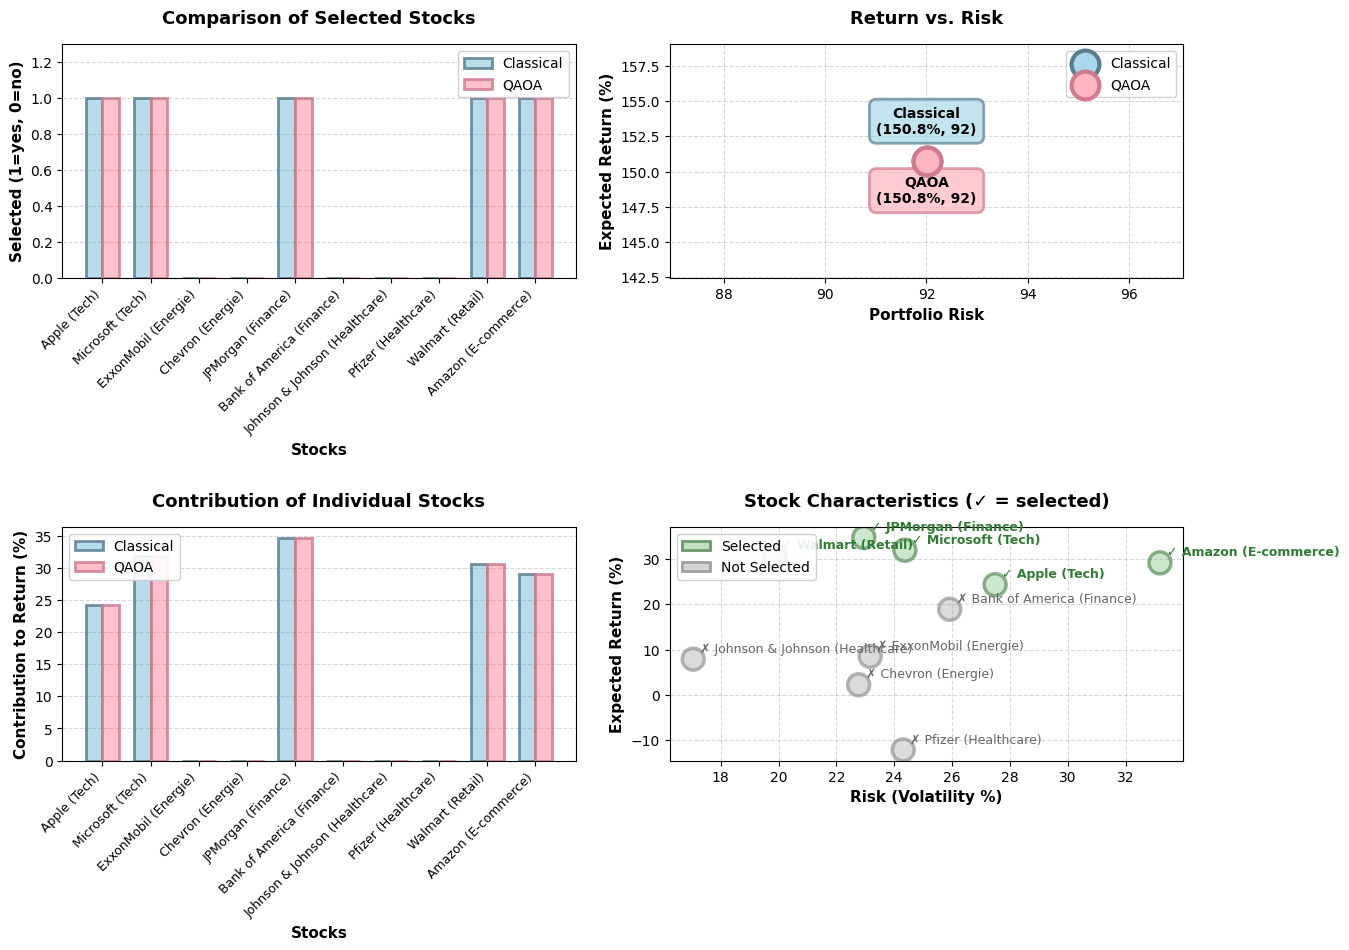

In [6]:
print(f"{'Objective function value':<35s} {exact_result.fval:>15.2f} {qaoa_result.fval:>15.2f}")
print(f"{'Total return (%)':<35s} {total_return_exact:>15.2f} {total_return_qaoa:>15.2f}")
print(f"{'Total risk':<35s} {total_risk_exact:>15.2f} {total_risk_qaoa:>15.2f}")
print(f"{'Number of selected stocks':<35s} {len(selected_exact):>15d} {len(selected_qaoa):>15d}")
print(f"{'Sharpe ratio (return/risk)':<35s} {total_return_exact/total_risk_exact:>15.3f} {total_return_qaoa/total_risk_qaoa:>15.3f}")

# Calculate difference
diff = abs(qaoa_result.fval - exact_result.fval)
diff_percent = (diff / abs(exact_result.fval)) * 100 if exact_result.fval != 0 else 0
print(f"{'Difference in objective function':<35s} {diff:>15.2f} ({diff_percent:.1f}%)")

if len(selected_exact) > 0 or len(selected_qaoa) > 0:

    pastel_blue = '#A8D8EA'
    pastel_pink = '#FFB6C1'
    pastel_green = '#C1E1C1'
    pastel_gray = '#D3D3D3'
    pastel_purple = '#E6B3E0'
    pastel_yellow = '#FFF9A8'

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.patch.set_facecolor('#FFFFFF')

    # Graph 1: Selected stocks
    ax1 = axes[0, 0]
    ax1.set_facecolor('#FFFFFF')
    x_pos = np.arange(n_assets)
    width = 0.35

    exact_binary = [1 if i in selected_exact else 0 for i in range(n_assets)]
    qaoa_binary = [1 if i in selected_qaoa else 0 for i in range(n_assets)]

    ax1.bar(x_pos - width / 2,
            exact_binary,
            width,
            label='Classical',
            alpha=0.85,
            color=pastel_blue,
            edgecolor='#5A7D8F',
            linewidth=2)
    ax1.bar(x_pos + width / 2,
            qaoa_binary,
            width,
            label='QAOA',
            alpha=0.85,
            color=pastel_pink,
            edgecolor='#D17A8F',
            linewidth=2)

    ax1.set_xlabel('Stocks', fontweight='bold', fontsize=11)
    ax1.set_ylabel('Selected (1=yes, 0=no)', fontweight='bold', fontsize=11)
    ax1.set_title('Comparison of Selected Stocks',
                  fontweight='bold',
                  pad=15,
                  fontsize=13)
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels(asset_names, rotation=45, ha='right', fontsize=9)
    ax1.legend(fontsize=10, framealpha=0.9)
    ax1.grid(axis='y', alpha=0.3, color='gray', linestyle='--')
    ax1.set_ylim([0, 1.3])

    # Graph 2: Return vs Risk
    ax2 = axes[0, 1]
    ax2.set_facecolor('#FFFFFF')

    if total_return_exact > 0 and total_return_qaoa > 0:
        ax2.scatter(total_risk_exact,
                    total_return_exact,
                    s=400,
                    label='Classical',
                    color=pastel_blue,
                    edgecolors='#5A7D8F',
                    linewidth=3,
                    zorder=5)
        ax2.scatter(total_risk_qaoa,
                    total_return_qaoa,
                    s=400,
                    label='QAOA',
                    color=pastel_pink,
                    edgecolors='#D17A8F',
                    linewidth=3,
                    zorder=5)

        ax2.annotate(
            f'Classical\n({total_return_exact:.1f}%, {total_risk_exact:.0f})',
            (total_risk_exact, total_return_exact),
            xytext=(0, 20),
            textcoords='offset points',
            fontsize=10,
            fontweight='bold',
            ha='center',
            bbox=dict(boxstyle='round,pad=0.5',
                      facecolor=pastel_blue,
                      alpha=0.7,
                      edgecolor='#5A7D8F',
                      linewidth=2))
        ax2.annotate(f'QAOA\n({total_return_qaoa:.1f}%, {total_risk_qaoa:.0f})',
                     (total_risk_qaoa, total_return_qaoa),
                     xytext=(0, -30),
                     textcoords='offset points',
                     fontsize=10,
                     fontweight='bold',
                     ha='center',
                     bbox=dict(boxstyle='round,pad=0.5',
                               facecolor=pastel_pink,
                               alpha=0.7,
                               edgecolor='#D17A8F',
                               linewidth=2))

    ax2.set_xlabel('Portfolio Risk', fontweight='bold', fontsize=11)
    ax2.set_ylabel('Expected Return (%)', fontweight='bold', fontsize=11)
    ax2.set_title('Return vs. Risk', fontweight='bold', pad=15, fontsize=13)
    ax2.legend(fontsize=10, framealpha=0.9)
    ax2.grid(True, alpha=0.3, color='gray', linestyle='--')

    # Graph 3: Contribution to return
    ax3 = axes[1, 0]
    ax3.set_facecolor('#FFFFFF')

    returns_exact = [
        expected_returns[i] if i in selected_exact else 0
        for i in range(n_assets)
    ]
    returns_qaoa = [
        expected_returns[i] if i in selected_qaoa else 0
        for i in range(n_assets)
    ]

    ax3.bar(x_pos - width / 2,
            returns_exact,
            width,
            label='Classical',
            alpha=0.85,
            color=pastel_blue,
            edgecolor='#5A7D8F',
            linewidth=2)
    ax3.bar(x_pos + width / 2,
            returns_qaoa,
            width,
            label='QAOA',
            alpha=0.85,
            color=pastel_pink,
            edgecolor='#D17A8F',
            linewidth=2)

    ax3.set_xlabel('Stocks', fontweight='bold', fontsize=11)
    ax3.set_ylabel('Contribution to Return (%)', fontweight='bold', fontsize=11)
    ax3.set_title('Contribution of Individual Stocks',
                  fontweight='bold',
                  pad=15,
                  fontsize=13)
    ax3.set_xticks(x_pos)
    ax3.set_xticklabels(asset_names, rotation=45, ha='right', fontsize=9)
    ax3.legend(fontsize=10, framealpha=0.9)
    ax3.grid(axis='y', alpha=0.3, color='gray', linestyle='--')

    # Graph 4: Stock characteristics
    ax4 = axes[1, 1]
    ax4.set_facecolor('#FFFFFF')

    # Pastel colors for points - green for selected, gray for unselected
    colors = [
        pastel_green if i in selected_exact else pastel_gray
        for i in range(n_assets)
    ]
    edge_colors = [
        '#6B9B6B' if i in selected_exact else '#A0A0A0' for i in range(n_assets)
    ]

    ax4.scatter(volatility,
                expected_returns,
                s=250,
                alpha=0.8,
                c=colors,
                edgecolors=edge_colors,
                linewidth=2.5)

    for i in range(n_assets):
        symbol = '✓' if i in selected_exact else '✗'
        color = '#2E7D32' if i in selected_exact else '#666666'
        ax4.annotate(f'{symbol} {asset_names[i]}',
                     (volatility[i], expected_returns[i]),
                     xytext=(5, 5),
                     textcoords='offset points',
                     fontsize=9,
                     fontweight='bold' if i in selected_exact else 'normal',
                     color=color)

    ax4.set_xlabel('Risk (Volatility %)', fontweight='bold', fontsize=11)
    ax4.set_ylabel('Expected Return (%)', fontweight='bold', fontsize=11)
    ax4.set_title('Stock Characteristics (✓ = selected)',
                  fontweight='bold',
                  pad=15,
                  fontsize=13)
    ax4.grid(True, alpha=0.3, color='gray', linestyle='--')

    # Add legend for graph 4
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor=pastel_green,
              edgecolor='#6B9B6B',
              linewidth=2,
              label='Selected'),
        Patch(facecolor=pastel_gray,
              edgecolor='#A0A0A0',
              linewidth=2,
              label='Not Selected')
    ]
    ax4.legend(handles=legend_elements,
               fontsize=10,
               framealpha=0.9,
               loc='upper left')

    plt.tight_layout(pad=2.5)

    # Save
    output_filename = 'portfolio_results_pastel.png'
    try:
        plt.savefig(output_filename,
                    dpi=150,
                    bbox_inches='tight',
                    facecolor='#FAFAFA')
        import os
        print(f"\n Graphs saved to: {os.path.abspath(output_filename)}")
    except Exception as e:
        print(f"\n Cannot save graph: {e}")

    plt.show()

## Detailed solution analysis

In [7]:
if len(selected_exact) > 0 and len(selected_qaoa) > 0:
    print(
        f"{'Objective function':<30s} {exact_result.fval:>15.2f} {qaoa_result.fval:>15.2f} "
        f"{abs(qaoa_result.fval - exact_result.fval):>15.2f}")

    print(
        f"{'Total return (%)':<30s} {total_return_exact:>15.2f} {total_return_qaoa:>15.2f} "
        f"{abs(total_return_qaoa - total_return_exact):>15.2f}")

    print(
        f"{'Total risk':<30s} {total_risk_exact:>15.2f} {total_risk_qaoa:>15.2f} "
        f"{abs(total_risk_qaoa - total_risk_exact):>15.2f}")

    print(
        f"{'Number of stocks':<30s} {len(selected_exact):>15d} {len(selected_qaoa):>15d} "
        f"{abs(len(selected_qaoa) - len(selected_exact)):>15d}")

    if total_risk_exact > 0 and total_risk_qaoa > 0:
        sr_exact = total_return_exact / total_risk_exact
        sr_qaoa = total_return_qaoa / total_risk_qaoa
        print(f"{'Sharpe ratio':<30s} {sr_exact:>15.3f} {sr_qaoa:>15.3f} "
              f"{abs(sr_qaoa - sr_exact):>15.3f}")

    print("-" * 77)

    # Analysis of agreement
    print("\nANALYSIS:")
    if set(selected_exact) == set(selected_qaoa):
        print(" QAOA found IDENTICAL portfolio as classical solver!")
    else:
        print(" QAOA found DIFFERENT portfolio:")
        only_exact = set(selected_exact) - set(selected_qaoa)
        only_qaoa = set(selected_qaoa) - set(selected_exact)

        if only_exact:
            print(
                f"    - Only in classical: {[asset_names[i] for i in only_exact]}"
            )
        if only_qaoa:
            print(f"    - Only in QAOA: {[asset_names[i] for i in only_qaoa]}")

        diff_percent = abs(qaoa_result.fval - exact_result.fval) / abs(
            exact_result.fval) * 100
        if diff_percent < 5:
            print(
                f"    But the difference is small ({diff_percent:.1f}%), so it's OK!"
            )
        else:
            print(
                f"    Difference is larger ({diff_percent:.1f}%), increase reps or maxiter"
            )


Objective function                     -436.98         -436.98            0.00
Total return (%)                        150.75          150.75            0.00
Total risk                               92.00           92.00            0.00
Number of stocks                             5               5               0
Sharpe ratio                             1.639           1.639           0.000
-----------------------------------------------------------------------------

ANALYSIS:
 QAOA found IDENTICAL portfolio as classical solver!


## Experimentation

Try modifying the following parameters and observe changes in the solution:

1. **risk_factor / return_factor**: Change the ratio between risk and return
   - Example: Set `risk_factor=2.0, return_factor=0.5` → prefers safer stocks

2. **budget**: Change the number of stocks you want to select
   - Example: Set `budget=2` → selects only the two best stocks

3. **reps in QAOA**: Increase the number of layers for potentially better results
   - Example: Set `reps=5` → may find better solutions (but slower)

4. **expected_returns / volatility**: Modify the stock characteristics
   - Experiment with your own real market data
  
## If nothing is found
1. Increase return_factor (e.g., to 5.0 or 10.0)
2. Decrease risk_factor (e.g., to 0.001)
3. Increase penalty (e.g., to 200.0)
4. Or change approach - use ConstrainedQuadraticProgram

In [8]:
import sys
print(f"\nPython Version: {sys.version}")
import numpy as np
print(f"numpy: {np.__version__}")
import matplotlib
print(f"matplotlib: {matplotlib.__version__}")
import pandas as pd
print(f"pandas: {pd.__version__}")
import qiskit
print(f"qiskit: {qiskit.__version__}")
import qiskit_optimization
print(f"qiskit-optimization: {qiskit_optimization.__version__}")
import qiskit_algorithms
print(f"qiskit-algorithms: {qiskit_algorithms.__version__}")
import qiskit_aer
print(f"qiskit-aer: {qiskit_aer.__version__}")
import yfinance as yf
print(f"yfinance: {yf.__version__}")


Python Version: 3.13.5 | packaged by Anaconda, Inc. | (main, Jun 12 2025, 16:37:03) [MSC v.1929 64 bit (AMD64)]
numpy: 2.3.3
matplotlib: 3.10.6
pandas: 2.3.2
qiskit: 2.2.1
qiskit-optimization: 0.7.0
qiskit-algorithms: 0.4.0
qiskit-aer: 0.17.2
yfinance: 0.2.66
